# 📊 Housing Market Data Fetcher
This notebook pulls real-time housing data from FRED and Yahoo Finance to analyze potential disruptions.

In [38]:
import pandas as pd
import ssl
import certifi
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt

# Step 1: Set up SSL context to fix certificate issue
context = ssl.create_default_context(cafile=certifi.where())

## 📈 1. Pull Housing-Related Economic Data from FRED

In [39]:
# Step 2: Fetch FRED housing starts data using urllib with SSL context
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=HOUST"
with urllib.request.urlopen(url, context=context) as response:
    csv_data = response.read().decode('utf-8')


## 💼 2. Pull Real Estate Stocks from Yahoo Finance

In [40]:
# Step 3: Load CSV into pandas
housing_starts = pd.read_csv(StringIO(csv_data))
housing_starts.columns = ['Date', 'Housing Starts']
housing_starts['Date'] = pd.to_datetime(housing_starts['Date'])

## 💾 3. Plot Data & Save

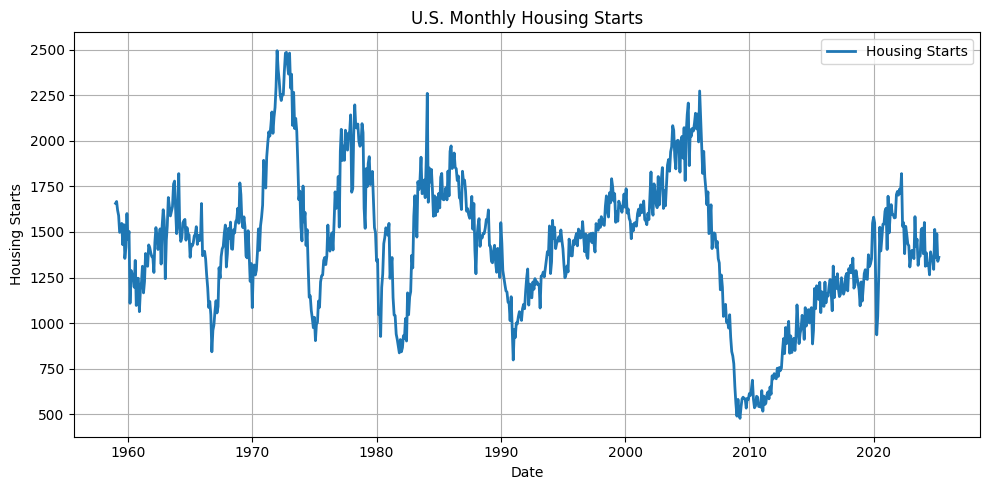


⚠️ Disruption Events (≥10% month-to-month drop):
      Date  Housing Starts   Change %
1959-10-01            1355 -12.012987
1960-03-01            1109 -26.214238
1960-09-01            1097 -18.377976
1960-12-01            1063 -14.686998
1961-04-01            1166 -11.128049
1962-09-01            1324 -12.722479
1963-01-01            1244 -20.460358
1964-03-01            1517 -16.648352
1966-01-01            1370 -17.270531
1966-10-01             843 -19.407266
1967-12-01            1308 -14.954486
1969-07-01            1368 -10.471204
1969-11-01            1229 -11.006517
1970-01-01            1085 -18.236624
1973-04-01            2084 -11.881607
1973-10-01            1677 -10.512273
1973-12-01            1526 -11.484919
1974-03-01            1555 -11.244292
1974-05-01            1426 -11.263223
1974-07-01            1316 -13.020489
1974-08-01            1142 -13.221884
1975-02-01             904 -12.403101
1977-01-01            1527 -15.354767
1978-01-01            1718 -19.794585


In [41]:
import os
import pandas as pd
import ssl
import certifi
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt

# ─── 1. Fetch & Load ───────────────────────────────────────────────────────────

# SSL context using certifi
context = ssl.create_default_context(cafile=certifi.where())

# FRED URL for U.S. Housing Starts
fred_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=HOUST"

# Download & read into DataFrame
with urllib.request.urlopen(fred_url, context=context) as resp:
    csv_text = resp.read().decode("utf-8")
housing_starts = pd.read_csv(StringIO(csv_text))

# Rename and parse dates
housing_starts.columns = ['Date', 'Housing Starts']
housing_starts['Date'] = pd.to_datetime(housing_starts['Date'])
housing_starts['Housing Starts'] = pd.to_numeric(housing_starts['Housing Starts'], errors='coerce')

# ─── 2. Save Raw Data ──────────────────────────────────────────────────────────

# Target data directory (one level up from notebooks)
save_folder = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
os.makedirs(save_folder, exist_ok=True)

raw_csv = os.path.join(save_folder, "housing_starts.csv")
housing_starts.to_csv(raw_csv, index=False)

# ─── 3. Plot Time Series ────────────────────────────────────────────────────────

plt.figure(figsize=(10, 5))
plt.plot(housing_starts['Date'], housing_starts['Housing Starts'], label="Housing Starts", linewidth=2)
plt.title("U.S. Monthly Housing Starts")
plt.xlabel("Date")
plt.ylabel("Housing Starts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ─── 4. Detect Disruptions ─────────────────────────────────────────────────────

# Compute month-to-month % change
housing_starts['Change %'] = housing_starts['Housing Starts'].pct_change() * 100

# Flag any drop ≥ 10%
disruptions = housing_starts[housing_starts['Change %'] < -10]

print("\n⚠️ Disruption Events (≥10% month-to-month drop):")
print(disruptions[['Date','Housing Starts','Change %']].to_string(index=False))

# ─── 5. Save Disruptions ───────────────────────────────────────────────────────

disruptions_csv = os.path.join(save_folder, "housing_disruptions.csv")
disruptions.to_csv(disruptions_csv, index=False)

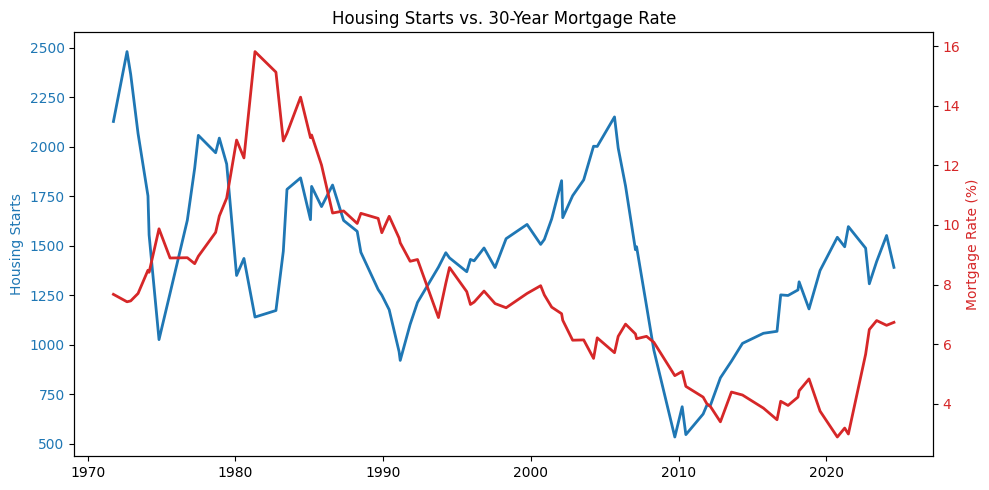

Pearson correlation: 0.27
                            OLS Regression Results                            
Dep. Variable:         Housing Starts   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.473
Date:                Thu, 22 May 2025   Prob (F-statistic):             0.0128
Time:                        19:07:16   Log-Likelihood:                -634.69
No. Observations:                  86   AIC:                             1273.
Df Residuals:                      84   BIC:                             1278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1177.

In [42]:
import os
import pandas as pd
import ssl
import certifi
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ─── 1. Setup SSL & Paths ─────────────────────────────────────────────────────────
ctx = ssl.create_default_context(cafile=certifi.where())
base = "/Users/fadibatshon/housing-disruption-radar"
data_dir = os.path.join(base, "data")
os.makedirs(data_dir, exist_ok=True)

# ─── 2. Load Housing Starts (you already have this) ───────────────────────────────
hs = pd.read_csv(os.path.join(data_dir, "housing_starts.csv"), parse_dates=["Date"])
hs.set_index("Date", inplace=True)

# ─── 3. Fetch Mortgage Rate from FRED ─────────────────────────────────────────────
mort_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=MORTGAGE30US"
with urllib.request.urlopen(mort_url, context=ctx) as r:
    mort_csv = r.read().decode("utf-8")
mort = pd.read_csv(StringIO(mort_csv))
mort.columns = ["Date", "Mortgage Rate"]
mort["Date"] = pd.to_datetime(mort["Date"])
mort.set_index("Date", inplace=True)

# Save mortgage series for future reference
mort.to_csv(os.path.join(data_dir, "mortgage_rate.csv"))

# ─── 4. Merge & Clean ─────────────────────────────────────────────────────────────
df = hs.join(mort, how="inner").dropna()
df["Mortgage Rate"] = pd.to_numeric(df["Mortgage Rate"], errors="coerce")

# ─── 5. Plot Dual-Axis ─────────────────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(df.index, df["Housing Starts"], color="tab:blue", label="Housing Starts", linewidth=2)
ax1.set_ylabel("Housing Starts", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(df.index, df["Mortgage Rate"], color="tab:red", label="30-Yr Mortgage Rate", linewidth=2)
ax2.set_ylabel("Mortgage Rate (%)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Housing Starts vs. 30-Year Mortgage Rate")
fig.tight_layout()
plt.show()

# ─── 6. Correlation & Regression ─────────────────────────────────────────────────
corr = df["Housing Starts"].corr(df["Mortgage Rate"])
print(f"Pearson correlation: {corr:.2f}")

X = sm.add_constant(df["Mortgage Rate"])
model = sm.OLS(df["Housing Starts"], X).fit()
print(model.summary())
